# Zillow Challenge

##  Data input

In [220]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import seterr,isneginf,array
from datetime import datetime
from pandas import compat
from operator import itemgetter
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.neighbors import KDTree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from IPython.display import Image

#import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 200)
pd.options.display.float_format = '{:20,.2f}'.format
compat.PY3 = False

def Decision_Tree_Image(decision_tree, feature_names, name="temp"):
    
    # Etrainport our decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree, out_file='images/' + name + '.dot', feature_names=feature_names)
    
    # Call graphviz to make an image file from our decision tree
    os.system("dot -T png images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    #if ylim is not None:
    #    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='neg_mean_absolute_error', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [209]:
train_f = "train_2016_v2.csv"
train = pd.read_csv(train_f, index_col = 'parcelid', parse_dates=['transactiondate'])
train['transactiondate'] = pd.to_datetime(train['transactiondate']).astype(int)

properties_f = "properties_2016.csv"
properties = pd.read_csv(properties_f, index_col = 'parcelid')

train_bak = train.join(properties) 

KeyboardInterrupt: 

In [3]:
#### TEST MODE  #####
def getdata(pcnt): 
    return train_bak.sample(frac=pcnt)

##  Feature creation

In [4]:
features_base = set()
features_created_custom = set()
features_created_null = set()

In [5]:
#################
#  _isnull
#################
def add_isnull(dfs,feature):
    featurename = feature+"_isnull"
    features_created_null.add(featurename)
    dfs[0][featurename] = dfs[0][feature].isnull()

In [6]:
#################
#  taxrate
#################
def add_taxrate(dfs):
    features_created_custom.add('taxrate')
    dfs[0]['taxrate'] = np.divide(dfs[0]['taxamount'],dfs[0]['taxvaluedollarcnt'])

In [7]:
#################
#  roomcntdiff
#################
def add_roomcntdiff(dfs):
    features_created_custom.add('roomcntdiff')
    dfs[0]['roomcntdiff'] = np.where(dfs[0]['roomcnt']==0, 
                                    np.negative(dfs[0]['bedroomcnt'].add(dfs[0]['bathroomcnt'])),
                                    dfs[0]['roomcnt']
                            )

In [8]:
#################
# add_transactioncnt
#################

def add_transactioncnt(dfs):
    features_created_custom.add('transactioncnt')
    n1 = 200  # square ft bucketing
    monthlag = 3
    cols = ['transactionmonth', 'regionidzip', 'calculatedbathnbr']

    dfs[0] = dfs[0].drop(['transactioncnt'], errors='ignore', axis=1)

    dfs[0]['transactionmonth']    = pd.to_datetime(dfs[0]['transactiondate']).dt.month
    dfs[0]['transactionmonthlag'] = np.subtract(dfs[0]['transactionmonth'],monthlag)    
    dfs[0]['calculatedfinishedsquarefeet_t'] = np.ceil(np.divide(dfs[0]['calculatedfinishedsquarefeet'], n1))

    sumdf = pd.DataFrame({'transactioncnt' : dfs[0].groupby([
                    'transactionmonth' 
                    ,'regionidzip' 
                    ,'roomcnt'
                    ,'calculatedfinishedsquarefeet_t'
                ]).size()}).reset_index()
    sumdf.rename(columns={'transactionmonth': 'transactionmonthlag'}, inplace=True)
    dfs[0] = pd.merge(dfs[0], sumdf, on=['transactionmonthlag' 
                                ,'regionidzip' 
                                ,'roomcnt'
                                 ,'calculatedfinishedsquarefeet_t'
                                ], how='left')    
    dfs[0] = dfs[0][dfs[0]['transactionmonthlag']>0]  # Drop sales done in earlier than monthlag months
    dfs[0] = dfs[0].drop(['transactionmonth','transactionmonthlag','calculatedfinishedsquarefeet_t'], axis=1)

In [9]:
#################
#  distanceavg
#################
def add_distanceavg(dfs):  
    # Convert to miles, 1 degree = 69 miles
    #df['latitudemi']  = df['latitude']* 5280 * 69/1e6
    #df['longitudemi'] *= df['longitude'] * 5280* 69/1e6

    features_created_custom.add('distanceavg')

    n1 = 500  # square ft   # TODO: exponentiate as it grows bigger
    n2 = 20000 # lot size
    dfs[0]['calculatedfinishedsquarefeet_t'] = np.ceil(np.divide(dfs[0]['calculatedfinishedsquarefeet'], n1))
    dfs[0]['lotsizesquarefeet_t'] = np.ceil(np.divide(dfs[0]['lotsizesquarefeet'], n2))    

    monthlag = 3
    dfs[0]['transactionmonth']    = pd.to_datetime(dfs[0]['transactiondate']).dt.month
    dfs[0]['transactionmonthlag'] = np.subtract(dfs[0]['transactionmonth'],monthlag)    
   
    n=3    # n-1 nearest neighbor
    dfs[0]['distanceavg'] = np.nan     # Unknown distance, one of feastures not available, assume 20
    distancefeatures = ['latitude', 'longitude']   # features to measure distance
    for i in dfs[0]['calculatedbathnbr'].unique():         # features to define comparables
        for k in dfs[0]['lotsizesquarefeet_t'].unique():   
            for l in dfs[0]['transactionmonthlag'].unique():
                if ((~np.isnan(i)) 
                        #& (~np.isnan(j)) 
                        & (~np.isnan(k)) 
                        & (~np.isnan(l)) 
                       ):
                    mask1 = (
                            (dfs[0]['calculatedbathnbr'] == i)   
                          #  & (df['bathroomcnt'] == j) 
                            & (dfs[0]['lotsizesquarefeet_t'] == k) 
                            & (dfs[0]['transactionmonth'] == l)
                           ) 
                    df_subset1 = dfs[0][mask1]
                    
                    mask2 = (
                            (dfs[0]['calculatedbathnbr'] == i)   
                          #  & (df['bathroomcnt'] == j) 
                            & (dfs[0]['lotsizesquarefeet_t'] == k) 
                            & (dfs[0]['transactionmonthlag'] == l)
                           ) 
                    df_subset2 = dfs[0][mask2]
                    
                    if ((len(df_subset1))>n-1 &
                         (len(df_subset2))>1):
                        kdt = KDTree(df_subset1.loc[:,distancefeatures], 
                                     leaf_size=30, 
                                     metric='euclidean')
                        dists, neighs=kdt.query(df_subset2.loc[:,distancefeatures], 
                                                k=n, 
                                                return_distance=True) 
                        distanceavg=dists.mean(axis=1)
                        #res = np.log(distanceavg)
                        #res[isneginf(res)]=0
                        dfs[0].loc[mask2,'distanceavg'] = distanceavg
    dfs[0] = dfs[0].drop(['calculatedfinishedsquarefeet_t','lotsizesquarefeet_t',
                         'transactionmonth','transactionmonthlag'], axis=1)
    
#['distanceavgmi']=train['distanceavg']* 69/1e6

In [10]:
def createfeatures(df, features):
    functions = {
                'taxrate': add_taxrate,
                'roomcntdiff':add_roomcntdiff,
                'transactioncnt':add_transactioncnt,
                'distanceavg':add_distanceavg   
                } 
    for f in features:
        functions[f]([df])

In [11]:
def createfeaturesnull(df):
    for f in (train.columns - ['logerror']):
        add_isnull([train],f)

In [12]:
train = getdata(1)

In [13]:
# Add null features
createfeaturesnull(train)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  from ipykernel import kernelapp as app


In [14]:
# Add custom features
createfeatures(train,[
               'taxrate',
               'roomcntdiff',
               'transactioncnt',
               'distanceavg'
              ])

In [15]:
#Binary
features_binary = {'hashottuborspa',
                'pooltypeid10',
                'pooltypeid2',
                'pooltypeid7',
                'fireplaceflag',
                'taxdelinquencyflag'}

for f in features_binary:
    train[f] = pd.Categorical(train[f]).codes

In [16]:
# Types
features_types = {'airconditioningtypeid',
                  'architecturalstyletypeid',
                  'buildingqualitytypeid',
                  'buildingclasstypeid',
                  'decktypeid',
                  'heatingorsystemtypeid',
                  'propertycountylandusecode',
                  'propertylandusetypeid',
                  'propertyzoningdesc',
                  'typeconstructiontypeid',
                  'storytypeid'}

for f in features_types:
    train[f] = pd.Categorical(train[f]).codes

In [17]:
train = train.fillna(-1)

In [18]:
train_full = train

##  Feature selection

In [19]:
features_created_null = set([
'airconditioningtypeid_isnull',
 'airconditioningtypeid_isnull_isnull',
 'architecturalstyletypeid_isnull',
 'architecturalstyletypeid_isnull_isnull',
 'assessmentyear_isnull',
 'assessmentyear_isnull_isnull',
 'basementsqft_isnull',
 'basementsqft_isnull_isnull',
 'bathroomcnt_isnull',
 'bathroomcnt_isnull_isnull',
 'bedroomcnt_isnull',
 'bedroomcnt_isnull_isnull',
 'buildingclasstypeid_isnull',
 'buildingclasstypeid_isnull_isnull',
 'buildingqualitytypeid_isnull',
 'buildingqualitytypeid_isnull_isnull',
 'calculatedbathnbr_isnull',
 'calculatedbathnbr_isnull_isnull',
 'calculatedfinishedsquarefeet_isnull',
 'calculatedfinishedsquarefeet_isnull_isnull',
 'censustractandblock_isnull',
 'censustractandblock_isnull_isnull',
 'decktypeid_isnull',
 'decktypeid_isnull_isnull',
 'finishedfloor1squarefeet_isnull',
 'finishedfloor1squarefeet_isnull_isnull',
 'finishedsquarefeet12_isnull',
 'finishedsquarefeet12_isnull_isnull',
 'finishedsquarefeet13_isnull',
 'finishedsquarefeet13_isnull_isnull',
 'finishedsquarefeet15_isnull',
 'finishedsquarefeet15_isnull_isnull',
 'finishedsquarefeet50_isnull',
 'finishedsquarefeet50_isnull_isnull',
 'finishedsquarefeet6_isnull',
 'finishedsquarefeet6_isnull_isnull',
 'fips_isnull',
 'fips_isnull_isnull',
 'fireplacecnt_isnull',
 'fireplacecnt_isnull_isnull',
 'fireplaceflag_isnull',
 'fireplaceflag_isnull_isnull',
 'fullbathcnt_isnull',
 'fullbathcnt_isnull_isnull',
 'garagecarcnt_isnull',
 'garagecarcnt_isnull_isnull',
 'garagetotalsqft_isnull',
 'garagetotalsqft_isnull_isnull',
 'hashottuborspa_isnull',
 'hashottuborspa_isnull_isnull',
 'heatingorsystemtypeid_isnull',
 'heatingorsystemtypeid_isnull_isnull',
 'landtaxvaluedollarcnt_isnull',
 'landtaxvaluedollarcnt_isnull_isnull',
 'latitude_isnull',
 'latitude_isnull_isnull',
 'logerror_isnull_isnull',
 'longitude_isnull',
 'longitude_isnull_isnull',
 'lotsizesquarefeet_isnull',
 'lotsizesquarefeet_isnull_isnull',
 'numberofstories_isnull',
 'numberofstories_isnull_isnull',
 'poolcnt_isnull',
 'poolcnt_isnull_isnull',
 'poolsizesum_isnull',
 'poolsizesum_isnull_isnull',
 'pooltypeid10_isnull',
 'pooltypeid10_isnull_isnull',
 'pooltypeid2_isnull',
 'pooltypeid2_isnull_isnull',
 'pooltypeid7_isnull',
 'pooltypeid7_isnull_isnull',
 'propertycountylandusecode_isnull',
 'propertycountylandusecode_isnull_isnull',
 'propertylandusetypeid_isnull',
 'propertylandusetypeid_isnull_isnull',
 'propertyzoningdesc_isnull',
 'propertyzoningdesc_isnull_isnull',
 'rawcensustractandblock_isnull',
 'rawcensustractandblock_isnull_isnull',
 'regionidcity_isnull',
 'regionidcity_isnull_isnull',
 'regionidcounty_isnull',
 'regionidcounty_isnull_isnull',
 'regionidneighborhood_isnull',
 'regionidneighborhood_isnull_isnull',
 'regionidzip_isnull',
 'regionidzip_isnull_isnull',
 'roomcnt_isnull',
 'roomcnt_isnull_isnull',
 'storytypeid_isnull',
 'storytypeid_isnull_isnull',
 'structuretaxvaluedollarcnt_isnull',
 'structuretaxvaluedollarcnt_isnull_isnull',
 'taxamount_isnull',
 'taxamount_isnull_isnull',
 'taxdelinquencyflag_isnull',
 'taxdelinquencyflag_isnull_isnull',
 'taxdelinquencyyear_isnull',
 'taxdelinquencyyear_isnull_isnull',
 'taxvaluedollarcnt_isnull',
 'taxvaluedollarcnt_isnull_isnull',
 'threequarterbathnbr_isnull',
 'threequarterbathnbr_isnull_isnull',
 'transactiondate_isnull',
 'transactiondate_isnull_isnull',
 'typeconstructiontypeid_isnull',
 'typeconstructiontypeid_isnull_isnull',
 'unitcnt_isnull',
 'unitcnt_isnull_isnull',
 'yardbuildingsqft17_isnull',
 'yardbuildingsqft17_isnull_isnull',
 'yardbuildingsqft26_isnull',
 'yardbuildingsqft26_isnull_isnull',
 'yearbuilt_isnull',
 'yearbuilt_isnull_isnull'        
    ])

In [178]:
features_created_custom = set([
                'taxrate',
               'roomcntdiff',
               'transactioncnt',
               'distanceavg'
    ])

In [179]:
features_base = set([
 ##########
 #  train data
 ##########
 'logerror', # Predictor variable 
         
 ##########
 #  Numeric attributes
 ##########
 # ROOMS
 'roomcnt',	#  Total number of rooms in the principal residence

 # BATHROOMS
 'bathroomcnt',	#  Number of bathrooms in home including fractional bathrooms
 'calculatedbathnbr',	#  Number of bathrooms in home including fractional bathroom
 'threequarterbathnbr',	#  Number of 3/4 bathrooms in house (shower + sink + toilet)
 'fullbathcnt',	#  Number of full bathrooms (sink, shower + bathtub, and toilet) present in home

 # BEDROOMS
 'bedroomcnt',	#  Number of bedrooms in home 
        
  # MEASUREMENTS
  'basementsqft', #  Finished living area below or partially below ground level
  'calculatedfinishedsquarefeet',	#  Calculated total finished living area of the home 
  'finishedfloor1squarefeet',	#  Size of the finished living area on the first (entry) floor of the home
  'finishedsquarefeet6',	# Base unfinished and finished area
  'finishedsquarefeet12',	# Finished living area
  'finishedsquarefeet13',	# Perimeter  living area
  'finishedsquarefeet15',	# Total area
  'finishedsquarefeet50',	#  Size of the finished living area on the first (entry) floor of the home
  'lotsizesquarefeet',	#  Area of the lot in square feet
        
 # FIREPLACE
 'fireplacecnt',	#  Number of fireplaces in a home (if any)

 # GARAGE
 'garagecarcnt',	#  Total number of garages on the lot including an attached garage
 'garagetotalsqft',	#  Total number of square feet of all garages on lot including an attached garage

 # TAXES
 'landtaxvaluedollarcnt',	# The assessed value of the land area of the parcel
'structuretaxvaluedollarcnt',	# The assessed value of the built structure on the parcel
 'taxamount',	# The total property tax assessed for that assessment year
 'taxvaluedollarcnt',	# The total tax assessed value of the parcel

 # POOL
 'poolcnt',	#  Number of pools on the lot (if any)
 'poolsizesum',	#  Total square footage of all pools on property

 # YARD
 'yardbuildingsqft17',	# Patio in  yard
 'yardbuildingsqft26',	# Storage shed/building in yard

 # BUILDING
 'numberofstories',	#  Number of stories or levels the home has
 'unitcnt',	#  Number of units the structure is built into (i.e. 2 = dupletrain, 3 = tripletrain, etc...)

 ##########
 #  Time
 ##########
#####    'transactiondate',   ## from train data
 'yearbuilt',	#  The Year the principal residence was built      
 'taxdelinquencyyear',	# Year for which the unpaid propert tatraines were due 
 'assessmentyear',	# The year of the property tax assessment 
     
 ##########
 #  Location
 ########## 
 'latitude',	#  Latitude of the middle of the parcel multiplied by 10e6
 'longitude',	#  Longitude of the middle of the parcel multiplied by 10e6        
 'regionidcounty',	# County in which the property is located
 'regionidcity',	#  City in which the property is located (if any)
 'regionidzip',	#  Zip code in which the property is located
 'regionidneighborhood',	# Neighborhood in which the property is located
 'rawcensustractandblock',	#  Census tract and block ID combined - also contains blockgroup assignment by etraintension
 'censustractandblock',	#  Census tract and block ID combined - also contains blockgroup assignment by etraintension        
        
 ##########
 #  Binary
 ##########         
 'hashottuborspa',	#  Does the home have a hot tub or spa - array([nan, True], dtype=object)
        # array([nan, True], dtype=object)
 'pooltypeid10',	#  Spa or Hot Tub - [array([ nan,   1.])]
        # array([ nan,   1.])
 'pooltypeid2',	#  Pool with Spa/Hot Tub - [array([ nan,   1.])]
        # array([ nan,   1.])
 'pooltypeid7',	#  Pool without hot tub - [array([ nan,   1.])]
        # array([ nan,   1.])
 'fireplaceflag',	#  Is a fireplace present in this home - array([nan, True], dtype=object)
        # array([nan, True], dtype=object)
 'taxdelinquencyflag',	# Property tatraines for this parcel are past due as of 2015 - array([nan, 'Y'], dtype=object)
        # array([nan, 'Y'], dtype=object)
        
 ##########
 #  Types
 ##########    
 'airconditioningtypeid', #  Type of cooling system present in the home (if any)
 'architecturalstyletypeid', #  Architectural style of the home (i.e. ranch, colonial, split-level, etc…) 
        # array([ nan,   7.,  21.,   8.,   2.,   3.,   5.,  10.,  27.])
 'buildingqualitytypeid',	#  Overall assessment of condition of the building from best (lowest) to worst (highest)
        # array([ nan,   7.,   4.,  10.,   1.,  12.,   8.,   3.,   6.,   9.,   5.,
        #11.,   2.])
 'buildingclasstypeid',	# The building framing type (steel frame, wood frame, concrete/brick) 
        # array([ nan,   3.,   4.,   5.,   2.,   1.])
 'decktypeid',	# Type of deck (if any) present on parcel
        # array([ nan,  66.])
 'heatingorsystemtypeid',	#  Type of home heating system
        # array([ nan,   2.,   7.,  20.,   6.,  13.,  18.,  24.,  12.,  10.,   1.,
        # 14.,  21.,  11.,  19.])
 'propertycountylandusecode',	#  County land use code i.e. it's zoning at the county level
        #array([nan,'010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200',
        #'010C', '0300', '1204', '100V', '01HC', '120C', '040V', '1214', ... 
        # ], dtype=object)
 'propertylandusetypeid',	#  Type of land use the property is zoned for
        # array([ 269.,  261.,   47.,   31.,  260.,  266.,  246.,  247.,  248.,
        # 263.,  265.,  275.,  267.,  264.,  270.,   nan])
 'propertyzoningdesc',	#  Description of the allowed land uses (zoning) for that property   
        # array([nan, 'LCA11*', 'LAC2', ..., 'WCR1400000', 'EMPYYY', 'RMM2*'], dtype=object)
 'typeconstructiontypeid',	#  What type of construction material was used to construct the home
        # array([ nan,   6.,   4.,  10.,  13.,  11.])
 'storytypeid',	#  Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.).  See tab for details.
        # array([ nan,   7.])

 ##########
 #  Misc
 ########## 
 #'fips',	#  Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details
        # array([ 6037.,  6059.,  6111.,    nan])
 #'parcelid',	#  Unique identifier for parcels (lots)   
])



In [180]:
features_to_keep = set()
features_to_keep = features_to_keep.union(
                            features_base,
                            features_created_custom,
                           # features_created_null
                            )

In [531]:
# WINNER
features_to_keep = set([
        'logerror',
        u'bathroomcnt', u'buildingqualitytypeid', 
        u'calculatedbathnbr',
       u'calculatedfinishedsquarefeet', u'latitude',
        u'longitude',
       u'pooltypeid2', 
        u'pooltypeid7', 
        u'propertycountylandusecode',
       u'propertylandusetypeid', 
        u'propertyzoningdesc', 
        u'taxdelinquencyflag',
       u'taxrate', u'roomcntdiff'
    ])

In [532]:
train_filtered = train_full
for column in train_full.columns:
    if column not in features_to_keep:
        train_filtered = train_filtered.drop(column, axis=1)

In [533]:
train_filtered.columns

Index([u'logerror', u'bathroomcnt', u'buildingqualitytypeid',
       u'calculatedbathnbr', u'calculatedfinishedsquarefeet', u'latitude',
       u'longitude', u'pooltypeid2', u'pooltypeid7',
       u'propertycountylandusecode', u'propertylandusetypeid',
       u'propertyzoningdesc', u'taxdelinquencyflag', u'taxrate',
       u'roomcntdiff'],
      dtype='object')

## Sample

In [534]:
def getsample(pcnt): 
    return train_filtered.sample(frac=pcnt)

In [535]:
train_sample = getsample(.1)
Y = train_sample[['logerror']]
X = train_sample.drop('logerror',axis=1)

## Modeling

In [536]:
max_depth = None
min_samples_split = int(round(len(X)/6, 0))
min_samples_leaf = int(round(len(X)/60, 0))

print("min_samples_split =", min_samples_split)
print("min_samples_split =", min_samples_leaf)

model = DecisionTreeRegressor(max_depth=max_depth, 
                              min_samples_split = min_samples_split,
                              min_samples_leaf = min_samples_leaf,
                              criterion = "mae")

('min_samples_split =', 1504)
('min_samples_split =', 150)


In [537]:
X.columns

Index([u'bathroomcnt', u'buildingqualitytypeid', u'calculatedbathnbr',
       u'calculatedfinishedsquarefeet', u'latitude', u'longitude',
       u'pooltypeid2', u'pooltypeid7', u'propertycountylandusecode',
       u'propertylandusetypeid', u'propertyzoningdesc', u'taxdelinquencyflag',
       u'taxrate', u'roomcntdiff'],
      dtype='object')

In [538]:
# Model statistics
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, Y, cv=5, n_jobs = 5, scoring='neg_mean_absolute_error')
print(scores, scores.mean())

(array([-0.06809446, -0.06416174, -0.06343045, -0.06681584, -0.07235385]), -0.06697127017666564)


In [539]:
# Fit regression model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.4)
model.fit(X_train, Y_train)

# Tree description
zip(X.columns[model.tree_.feature], 
    model.tree_.threshold, 
    model.tree_.value, 
    model.tree_.n_node_samples,
    model.tree_.children_left, 
    model.tree_.children_right)

[('calculatedfinishedsquarefeet', 1513.5, array([[ 0.008]]), 3611, 1, 6),
 ('taxrate', 0.020354591310024261, array([[ 0.004]]), 1761, 2, 5),
 ('latitude', 34021232.0, array([[ 0.005]]), 1611, 3, 4),
 ('taxrate', -2.0, array([[ 0.002]]), 855, -1, -1),
 ('taxrate', -2.0, array([[ 0.009]]), 756, -1, -1),
 ('taxrate', -2.0, array([[-0.0156]]), 150, -1, -1),
 ('longitude', -118374384.0, array([[ 0.0119]]), 1850, 7, 8),
 ('taxrate', -2.0, array([[ 0.0188]]), 649, -1, -1),
 ('taxrate', -2.0, array([[ 0.009]]), 1201, -1, -1)]

In [540]:
# Feature importance
sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), X_train.columns), 
             reverse=True)

[(0.3939, 'calculatedfinishedsquarefeet'),
 (0.2743, 'longitude'),
 (0.2039, 'taxrate'),
 (0.1279, 'latitude'),
 (0.0, 'taxdelinquencyflag'),
 (0.0, 'roomcntdiff'),
 (0.0, 'propertyzoningdesc'),
 (0.0, 'propertylandusetypeid'),
 (0.0, 'propertycountylandusecode'),
 (0.0, 'pooltypeid7'),
 (0.0, 'pooltypeid2'),
 (0.0, 'calculatedbathnbr'),
 (0.0, 'buildingqualitytypeid'),
 (0.0, 'bathroomcnt')]

In [541]:
# Zillow MAE (test)
Y_predict=model.predict(X_test)
print("MAE: ",metrics.mean_absolute_error(Y_test['logerror'], Y_predict))

('MAE: ', 0.066928595163374557)


##  Learning Curve

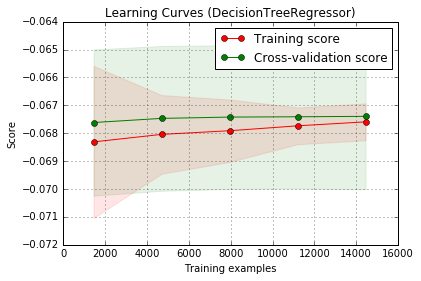

In [441]:
title = "Learning Curves (DecisionTreeRegressor)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(model, title, X, Y, ylim=(0.0, 1.01), cv=cv, n_jobs=25)
plt.show()

##  Feature / parameter search

In [414]:
# Parameter search
parameters = {#'max_depth':[], 
             'min_samples_leaf':[
                                len(X_train)/50,
                               # len(X_train)/40,
                               # len(X_train)/30
                                ],
              'min_samples_split':[
                                len(X_train)/6,
                               # len(X_train)/5,
                               # len(X_train)/3,
                                ]}
clf = GridSearchCV(model, parameters,n_jobs = 9)
clf.fit(X_train,Y_train)
sorted(clf.cv_results_.items())

[('mean_fit_time',
  array([ 8.54101006,  8.22041893,  7.45506032,  8.2014637 ,  7.9700431 ,
          7.32949098,  7.22526201,  6.77333744,  6.08810465])),
 ('mean_score_time',
  array([ 0.00123072,  0.00136709,  0.00117199,  0.00130169,  0.00114028,
          0.00107137,  0.00096138,  0.0010856 ,  0.00102401])),
 ('mean_test_score',
  array([ 0.00122942,  0.00107268,  0.00105931,  0.00082099,  0.00096201,
          0.00092878,  0.00081357,  0.00089703,  0.00074073])),
 ('mean_train_score',
  array([ 0.00253102,  0.00228528,  0.00176478,  0.00231324,  0.00217302,
          0.00172889,  0.0018033 ,  0.00149361,  0.00107885])),
 ('param_min_samples_leaf',
  masked_array(data = [324 324 324 406 406 406 541 541 541],
               mask = [False False False False False False False False False],
         fill_value = ?)),
 ('param_min_samples_split',
  masked_array(data = [2708 3249 5416 2708 3249 5416 2708 3249 5416],
               mask = [False False False False False False False False 

In [177]:
#Decision_Tree_Image(model, X_train.columns)

## Model evaluation

In [189]:
print ("Features: ", X.columns)
print ("Tree params: ")
print ("   max_depth ", max_depth)
print ("   min_samples_split ", min_samples_split)
print ("   min_samples_leaf ", min_samples_leaf)
print ("Result: ",metrics.mean_absolute_error(Y_test['logerror'], Y_predict))

('Features: ', Index([u'airconditioningtypeid', u'architecturalstyletypeid', u'basementsqft',
       u'bathroomcnt', u'bedroomcnt', u'buildingclasstypeid',
       u'buildingqualitytypeid', u'calculatedbathnbr', u'decktypeid',
       u'finishedfloor1squarefeet', u'calculatedfinishedsquarefeet',
       u'finishedsquarefeet12', u'finishedsquarefeet13',
       u'finishedsquarefeet15', u'finishedsquarefeet50',
       u'finishedsquarefeet6', u'fireplacecnt', u'fullbathcnt',
       u'garagecarcnt', u'garagetotalsqft', u'hashottuborspa',
       u'heatingorsystemtypeid', u'latitude', u'longitude',
       u'lotsizesquarefeet', u'poolcnt', u'poolsizesum', u'pooltypeid10',
       u'pooltypeid2', u'pooltypeid7', u'propertycountylandusecode',
       u'propertylandusetypeid', u'propertyzoningdesc',
       u'rawcensustractandblock', u'regionidcity', u'regionidcounty',
       u'regionidneighborhood', u'regionidzip', u'roomcnt', u'storytypeid',
       u'threequarterbathnbr', u'typeconstructiontypeid', u

## Model Execution

In [ ]:
sample_submission_f = '/Users/Jose/Desktop/Zillow/sample_submission.csv'
submission = pd.read_csv(sample_submission_f, index_col='ParcelId')

In [ ]:
#  ATTEMPT 2 - 
logerroravg = train['logerror'].mean()
print("Using logerroravg = ", logerroravg)

In [ ]:
X_all = properties

In [ ]:
# Prediction transaction date
def add_transactiondate(df):
    df['transactiondate'] = pd.datetime(2016,10,1)
    df['transactiondate'] = df['transactiondate'].astype(int)

add_transactiondate(X_all)

In [ ]:
# Add features


In [ ]:
for column in X_all.columns:
    if column not in features_to_keep:
        X_all = X_all.drop(column, axis=1)

In [ ]:
#  Check for missing data
print("Missing: ",X_test.columns.difference( X_all.columns))

In [ ]:
Y_all = model.predict(X_all)

In [ ]:
results = pd.DataFrame(index=X_all.index)
results.index.names = ['ParcelId']
results['201610'] = Y_all
results['201611'] = Y_all
results['201612'] = Y_all
results['201710'] = Y_all
results['201711'] = Y_all
results['201712'] = Y_all

In [ ]:
submission = submission.drop(submission.columns[0:], axis=1)
submission = submission.join(results)

# Use average for properties with missing data
submission.fillna(logerroravg, inplace=True)       
submission.columns

In [ ]:
# Round as per rules
submission = submission.round(4)

## Sanity Checks

In [ ]:
# Average log error
submission.describe().round(4)

In [ ]:
# Check for NaN
submission.isnull().sum()

In [ ]:
# Check if any duplicates
submission[submission.index.duplicated(keep=False)]

In [ ]:
# Check additional values in submission file
submission[~submission.index.isin(properties.index)]

In [ ]:
# Check additional values in properties file
properties[~properties.index.isin(submission.index)]

## Dump File

In [ ]:
# Write file
submission_f = '/Users/Jose/Desktop/Zillow/submission.csv'
submission_fh = open(submission_f, 'wb')
submission.to_csv(submission_fh, sep=',', header='true')
submission_fh.close()

## Historical Records

## Resources

Conclusions:
   * Average logerror = 0.011457219606756575
   * In general, data usually underestimates, with the etrainception of fewer high overestimates.
   * totalroomcnt:  ==0 is a mitrained bag.  != zero is overestimating

In [ ]:
# bedroomcnt
#plt.trainlabel('bedroomcnt')
#plt.ylabel('logerror')
#plt.scatter(train['bathroomcnt'], train['logerror'], 
#           alpha=1, s=2, color='r')
#plt.atrainis([0, 10,-5, 5])
#plt.show()

#date
#plt.trainlabel('transactiondate')
#plt.ylabel('logerror')
#plt.scatter(train['bedroomcnt'], train['logerror'], alpha=1, s=2, color='r')
#plt.atrainis(['2016-01-01', '2017-01-01',-5, 5])
#plt.gcf().autofmt_traindate()
#plt.show()

#import matplotlib as mpl
#plt.trainlabel('longitude')
#plt.ylabel('latitude')
#plt.scatter(train['longitude'], train['latitude'], c=train['logerror'], s=20, lw=0, cmap='seismic')
#plt.atrainis([min(train['longitude']), matrain(train['longitude']),min(train['latitude']), matrain(train['latitude'])])
#plt.colorbar()
#plt.show()

#train2 = train.query('logerror < -2.')

#train2 = train.query('roomcnt == 0 ')

#train2 = train.query('bedroomcnt > 2')

#train2 = train.sample(frac=.10)

#plt.trainlabel('longitude')
#plt.ylabel('latitude')
#plt.scatter(train2['longitude'], train2['latitude'], c=train2['logerror'], s=20, lw=0, cmap='seismic')
#plt.colorbar()
#plt.show()